The main goal of this work is to implement machine learning models from scratch in order to deeply understand the algorithms. That is why I tried not to use any library methods and not pay much attention to the final score, as long as the scores of the self-made models are similar to the scores of the sklearn models with the same hyperparameters.

As a dataset, I used Boston house prices dataset that comes with the scikit-learn library.
The main idea is to predict the median value of owner-occupied homes in $1000's.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
import missingno 
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

## Loading dataset

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = pd.Series(boston.target)

In [3]:
X['price'] = Y
X = X.sample(frac=1, random_state=42)
X_train = X[:404]
X_test = X[404:]
y_tr = X_train['price']
X_tr = X_train.drop('price', axis=1)
y_te = X_test['price']
X_te = X_test.drop('price', axis=1)

## EDA

In [4]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.789989,11.568069,11.214059,0.069307,0.554524,6.284824,69.119307,3.792258,9.660891,408.960396,18.481931,356.293020,12.825520,22.505693
std,9.132761,24.269648,6.925462,0.254290,0.116408,0.723759,28.034606,2.142651,8.736073,169.685166,2.157322,92.058615,7.308772,9.379273
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.920000,5.000000
25%,0.081960,0.000000,5.190000,0.000000,0.452000,5.878750,45.475000,2.097050,4.000000,281.000000,17.400000,375.085000,7.092500,16.675000
50%,0.262660,0.000000,9.690000,0.000000,0.538000,6.210000,77.500000,3.167500,5.000000,330.000000,19.100000,391.305000,11.560000,21.150000
75%,3.717875,12.500000,18.100000,0.000000,0.624000,6.620500,94.425000,5.118000,24.000000,666.000000,20.200000,395.810000,17.167500,25.025000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 173 to 207
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     404 non-null    float64
 1   ZN       404 non-null    float64
 2   INDUS    404 non-null    float64
 3   CHAS     404 non-null    float64
 4   NOX      404 non-null    float64
 5   RM       404 non-null    float64
 6   AGE      404 non-null    float64
 7   DIS      404 non-null    float64
 8   RAD      404 non-null    float64
 9   TAX      404 non-null    float64
 10  PTRATIO  404 non-null    float64
 11  B        404 non-null    float64
 12  LSTAT    404 non-null    float64
 13  price    404 non-null    float64
dtypes: float64(14)
memory usage: 47.3 KB


<AxesSubplot:>

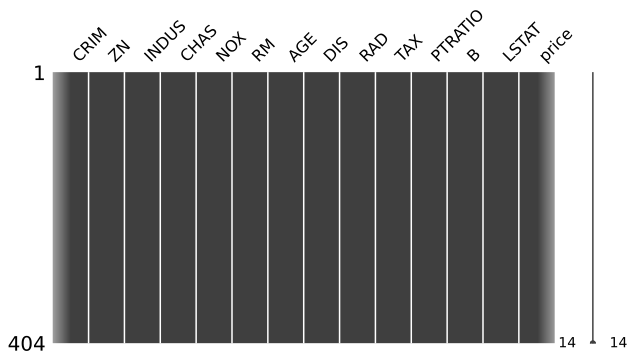

In [7]:
missingno.matrix(X_train, figsize = (10,5))

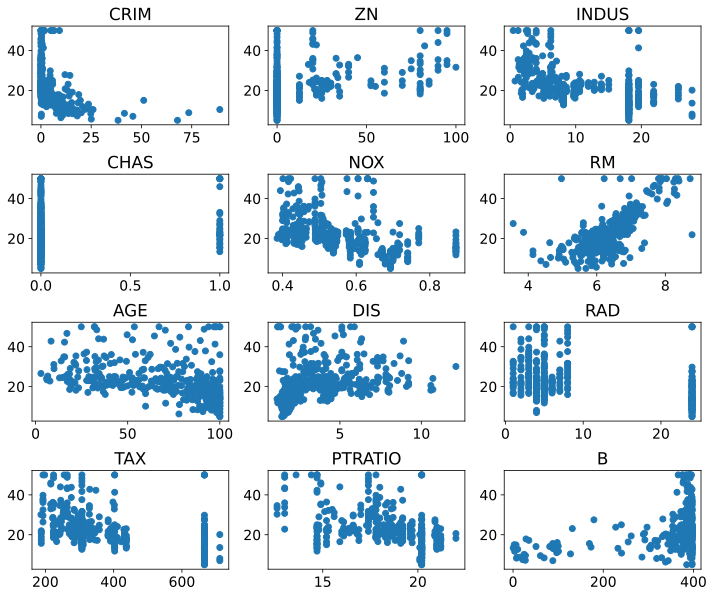

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = ax.flatten()
g = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
fig.set_size_inches(12, 10)
fig.subplots_adjust(wspace=0.2, hspace=0.5)

for f, g in zip(X_tr.columns, g):
    g.scatter(X_tr[f], y_tr)
    g.set_title(f)


All features in the dataset are numerical. There are no missing values to fill in.
Let's do the first check with linear regression and see if we have any unnecessary features that we can omit.

Standartization

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_tr)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=boston.feature_names)

X_test_scaled = scaler.fit_transform(X_te)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=boston.feature_names)

First check

In [10]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_tr)
test_pred = lr.predict(X_test_scaled)
train_pred = lr.predict(X_train_scaled)
print(f'R2 on training dataset: {r2(y_tr, train_pred)}')
print(f'R2 on testing dataset: {r2(y_te, test_pred)}')

R2 on training dataset: 0.7499835922256721
R2 on testing dataset: 0.6642284195038759


In [11]:
important_features = [
    feature
    for feature, weight in zip(boston.feature_names, lr.coef_.flatten())
    if np.abs(weight) > 0.5]

print(important_features)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


## Handmade models

Since it seems like the following features don't contribute a lot of information, we drop them off to simplify our dataset.

In [12]:
X_tr = X_tr.drop(['AGE'], axis=1)
X_te = X_te.drop(['AGE'], axis=1)
X_tr = X_tr.drop(['INDUS'], axis=1)
X_te = X_te.drop(['INDUS'], axis=1)

### Linear Regression

In [13]:
class MyLinearRegression():
    
    # Setting weights and an intercept equal to 1 as the first guess.
    
    def __init__(self, train_data):
        
        self.features = train_data.columns
        self.weights = [1 for x in range(len(self.features))]
        self.b = 1
        self.prediction = None
    
    # The fit function returns the weights and the intercept (b).
    # The weights and the intercept are found using the gradient descent algorithm:
    # we make the first prediction using the coefficients from the function above, find the antigradient
    # of the loss function (MSE) and multiply it by the learning rate and the current weights. 
    # Now we have 'steps' that we add to the previous weights.
    # It is repeated until we reach the max_iter value. The last found coefficients will be our model configurations.
    # lrw stands for learning rate for weights, lrb - for learning rate for an intercept.
    
    def fit(self, train_data, train_target, max_iter, lrw, lrb):
        
        self.prediction = self.b
        for w, x in zip(self.weights, self.features):
            self.prediction += w*train_data[x]
        
        antigradient = []
        for x in self.features:
            antigradient.append(-sum(-2*train_data[x]*(train_target - self.prediction)))
        antib = -sum(-2*(train_target - self.prediction))
        n = 0
        
        while n <= max_iter:
        
            n += 1
            self.weights = [x+y*lrw for x, y in zip(self.weights, antigradient)]
            self.b += antib*lrb
            
            self.prediction = self.b
            for w, x in zip(self.weights, self.features):
                self.prediction += w*train_data[x]
            
            antigradient = []
            for x in self.features:
                antigradient.append(-sum(-2*train_data[x]*(train_target - self.prediction)))
            antib = -sum(-2*(train_target - self.prediction))
            
    # The predict function makes a prediction based on the weights found in the fit function.
    
    def predict(self, data):
        
        self.prediction = self.b
        for w, x in zip(self.weights, self.features):
            self.prediction += w*data[x]
        
        return self.prediction
    
    # The info function returns the coefficients of our model.
    
    def info(self):
        
        return self.weights, self.b
            
            
            

In [14]:
%%time 
mylr = MyLinearRegression(X_tr)
mylr.fit(X_tr, y_tr, 
         max_iter=800000, 
         lrw=0.000000001, 
         lrb=0.000005)

CPU times: user 31min 57s, sys: 15.1 s, total: 32min 12s
Wall time: 32min 9s


In [15]:
mylr.info()

([-0.08722075884884693,
  0.04113550632017303,
  1.1180503670784396,
  1.017215306160977,
  1.793808814233193,
  -0.7065760598148106,
  0.36723303111405026,
  -0.01908355014357054,
  -0.7618307097458065,
  0.009049201040070287,
  -0.7031121995666757],
 37.25295041662836)

In [16]:
tr_pred = mylr.predict(X_tr)
te_pred = mylr.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, tr_pred)}')
print(f'R2 on the testing dataset: {r2(y_te, te_pred)}')

R2 on the training dataset: 0.7144173987068297
R2 on the testing dataset: 0.6451598333430784


Let's see how the sklearn model performs:

In [17]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)
test_pred = lr.predict(X_te)
train_pred = lr.predict(X_tr)
print(f'R2 on the training dataset: {r2(y_tr, train_pred)}')
print(f'R2 on the testing dataset: {r2(y_te, test_pred)}')

R2 on the training dataset: 0.7496234765570612
R2 on the testing dataset: 0.6918622804048744


In [18]:
print(lr.coef_, lr.intercept_)

[-1.03258231e-01  5.07084327e-02  2.34028401e+00 -1.68210030e+01
  3.68297000e+00 -1.55795632e+00  3.31370763e-01 -1.49391602e-02
 -9.13647404e-01  8.85219506e-03 -5.34734047e-01] 37.735670251078254


### Decision Tree Regressor

In [19]:
class MyDecisionTree():
    
    def __init__(self, x_df, y_df, max_depth, min_samples_leaf):
        
        self.data = x_df
        self.data['target'] = y_df
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    # Build_tree initiates the first split and creates the next nodes by calling the node function.
    
    def build_tree(self):
    
        self.tree = self.split(self.data)
        self.tree['left'] = self.node(self.tree['left'], 1)
        self.tree['right'] = self.node(self.tree['right'], 1)
    
    # The node function checks if we have reached the max_depth and splits the node if not.
    # It also calls the get_value function if there is nothing to split anymore or max_depth has been reached.
    
    def node(self, data, depth):
        
        if depth < self.max_depth:
            nodes = self.split(data)
            if nodes == 'no_split':
                return self.get_value(data)
            else:
                nodes['left'] = self.node(nodes['left'], depth+1)
                nodes['right'] = self.node(nodes['right'], depth+1)
                return nodes
        
        if depth == self.max_depth:
            return self.get_value(data)
    
    # The split function iterates trough all the values of all the features in the dataset, 
    # at each step devides the dataset into two subsets according to the current value,
    # calls the inf_gain function (calculates the information gain) and store 
    # the feature name, the treshold value and the subsets when the information gain is the biggest and 
    # the number of samples in each subset more than min_samples_leaf.
    # If the information gain hasn't increased, the function returns 'no_split'.
    
    def split(self, data):
    
        max_ig = 0
        split = 'no_split'
        for feature in data.columns[:-1]:
            for treshold in data[feature]:
                left = data.loc[data[feature] <= treshold]
                right = data.loc[data[feature] > treshold]
                ig = self.inf_gain(left, right)
                if ig > max_ig and len(left) >= self.min_samples_leaf and len(right) >= self.min_samples_leaf:
                    max_ig = ig
                    split = {'feature': feature, 'treshold': treshold, 'left': left, 'right': right}
        return split
    
    # The inf_gain function calculates the level of variance in the target values before and after splitting 
    # the dataset and measures the information gain by comparing these levels.
    
    def inf_gain(self, left, right):
    
        var_before = sum((self.data['target'].mean() - self.data['target'])**2)
        var_left = sum((left['target'].mean() - left['target'])**2)
        var_right = sum((right['target'].mean() - right['target'])**2)
        inf_gain = var_before - (len(left)/len(self.data))*var_left - (len(right)/len(self.data))*var_right
        return inf_gain
    
    # The get_value function returns the average value of the target values that the given node contains.
    
    def get_value(self, data):
    
        return data['target'].mean()

    # The predict function iterates trough the test data, calls the each_row function for each row
    # and stores the predictions in a list.
    
    def predict(self, data):
    
        prediction = []
        for i in range(len(data)):
            sample = data.iloc[i]
            prediction.append(self.each_row(sample, self.tree))
        return prediction
    
    # The each_row function compares the value of the test data with the threshold from the built tree: 
    # if it is less then the treshold, it goes to the left subtree, otherwise - to the right.
    # If there is no subtree anymore, the function returns the predicted value.
    
    def each_row(self, sample, tree):
    
        if sample[tree['feature']] <= tree['treshold']:
            if type(tree['left']) == dict:
                return self.each_row(sample, tree['left'])
            else:
                return tree['left']
        else:
            if type(tree['right']) == dict:
                return self.each_row(sample, tree['right'])
            else:
                return tree['right']
    
    # The get_tree function returns information about the generated decision tree.
    
    def get_tree(self):
        
        return self.tree
    

In [20]:
Xx_tr = X_tr.copy()

In [21]:
%%time
mytree = MyDecisionTree(Xx_tr, y_tr, 
                        max_depth=4,
                        min_samples_leaf=1)
mytree.build_tree()

CPU times: user 11.4 s, sys: 326 ms, total: 11.8 s
Wall time: 11.1 s


In [22]:
pred_train = mytree.predict(X_tr)
pred_test = mytree.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, pred_train)}')
print(f'R2 on the testing dataset: {r2(y_te, pred_test)}')

R2 on the training dataset: 0.874661348313563
R2 on the testing dataset: 0.8236100658997092


Nice😊 

Let's see what sklearn tree can give us

In [23]:
dt = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf=1,
                           random_state=42)
dt.fit(X_tr, y_tr)
train_pred = dt.predict(X_tr)
test_pred = dt.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, train_pred)}')
print(f'R2 on the testing dataset: {r2(y_te, test_pred)}')

R2 on the training dataset: 0.8791612843408819
R2 on the testing dataset: 0.7733848132761878


## Random forest

To build a random forest we need to alter the Decision tree model a little bit:

- to add new hyperparameters: n_estimators, max_features;

- each new tree should learn from the bootstrapped data;

- at each split the algorithm should consider max_features random features of the original data;

- the algorithm has to build n_estimators trees and store them;

- prediction must be formed as average values of all the trees predictions;


In [24]:
class MyRandomForest():
    
     # adding some new hyperparameters
        
    def __init__(self, x_df, y_df, max_depth, min_samples_leaf, n_estimators, max_features):
        
        self.data = x_df
        self.data['target'] = y_df
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.forest = None
    
    # bootstrapping the original data for creating multiple different models from a single training dataset
    
    def build_trees(self):
        
        self.forest = []
        n = 0
        while n < self.n_estimators:
            n += 1
            bootstrapped_data = self.data.sample(frac=1, replace=True)
            tree = self.split(bootstrapped_data)
            tree['left'] = self.node(tree['left'], 1)
            tree['right'] = self.node(tree['right'], 1)
            self.forest.append(tree)
        
    def node(self, data, depth):
        
        if depth < self.max_depth:
            nodes = self.split(data)
            if nodes == 'no_split':
                return data['target'].mean()
            else:
                nodes['left'] = self.node(nodes['left'], depth+1)
                nodes['right'] = self.node(nodes['right'], depth+1)
                return nodes
        
        if depth == self.max_depth:
            return data['target'].mean()
    
    def split(self, data):
    
        max_ig = 0
        split = 'no_split'
        random_features = random.sample(sorted(data.columns[:-1]), self.max_features)
        for feature in random_features:
            for treshold in data[feature]:
                left = data.loc[data[feature] <= treshold]
                right = data.loc[data[feature] > treshold]
                ig = self.inf_gain(left, right)
                if ig > max_ig and len(left) >= self.min_samples_leaf and len(right) >= self.min_samples_leaf:
                    max_ig = ig
                    split = {'feature': feature, 'treshold': treshold, 'left': left, 'right': right}
        return split
    
    def inf_gain(self, left, right):
    
        var_before = sum((self.data['target'].mean() - self.data['target'])**2)
        var_left = sum((left['target'].mean() - left['target'])**2)
        var_right = sum((right['target'].mean() - right['target'])**2)
        inf_gain = var_before - (len(left)/len(self.data))*var_left - (len(right)/len(self.data))*var_right
        return inf_gain
    
    # taking an average value of all the trees' predictions
    
    def predict(self, data):
    
        tree_preds = []
        for tree in self.forest:
            single_tr_pred = []
            for i in range(len(data)):
                sample = data.iloc[i]
                single_tr_pred.append(self.each_row(sample, tree))
            tree_preds.append(single_tr_pred)
        
        forest_pred = []
        for i in range(len(tree_preds[0])):
            obj = []
            for j in range(len(tree_preds)):
                obj.append(tree_preds[j][i])
            forest_pred.append(sum(obj)/len(obj))
        return forest_pred
        
    
    def each_row(self, sample, tree):
    
        if sample[tree['feature']] <= tree['treshold']:
            if type(tree['left']) == dict:
                return self.each_row(sample, tree['left'])
            else:
                return tree['left']
        else:
            if type(tree['right']) == dict:
                return self.each_row(sample, tree['right'])
            else:
                return tree['right']
    
    def get_forest(self):
        
        return self.forest
    

In [25]:
Xx_tr = X_tr.copy()

In [26]:
%%time
rf = MyRandomForest(Xx_tr, y_tr, 
                    max_depth=4, 
                    n_estimators=10,
                    min_samples_leaf=2,
                    max_features=10)
rf.build_trees()

CPU times: user 1min 41s, sys: 618 ms, total: 1min 41s
Wall time: 1min 41s


In [27]:
pred_train = rf.predict(X_tr)
pred_test = rf.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, pred_train)}')
print(f'R2 on the testing dataset: {r2(y_te, pred_test)}')

R2 on the training dataset: 0.8860976310707996
R2 on the testing dataset: 0.7975223673945177


In [28]:
clf = RandomForestRegressor(max_depth=4, 
                            max_features=10, 
                            n_estimators=10,
                            min_samples_leaf=2)
clf.fit(X_tr, y_tr)
train_pred = clf.predict(X_tr)
test_pred = clf.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, train_pred)}')
print(f'R2 on the testing dataset: {r2(y_te, test_pred)}')

R2 on the training dataset: 0.8951996547905388
R2 on the testing dataset: 0.7790681498542914


## Gradient Boosted Decision Trees

In order to implement the gradient method we need to sequentially build base estimators, each attempting to reduce the bias of the combined estimator.

 - we add learning_rate hyperparameter that shrinks each tree's output;
 - we also add columns 'temporal_predict' and 'antigradient' to the dataset to store current models outputs and the antigradient that the next estimator needs to reduce.
 - we take the sum of the all estimators predictions as the final prediction.

In [29]:
class MyGradientBoosting():
        
    def __init__(self, x_df, y_df, max_depth, min_samples_leaf, n_estimators, max_features, learning_rate):
        
        self.data = x_df
        self.max_depth = max_depth
        self.data['target'] = y_df
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.data['temporal_predict'] = 0
        self.data['antigradient'] = 2 * (self.data['target'] - self.data['temporal_predict'])
        self.forest = None
        self.learn_rate = learning_rate
        
    def build_trees(self):
       
        self.forest = []
        n = 0
        while n < self.n_estimators:
            n += 1
            tree = self.split(self.data)
            tree['left'] = self.node(tree['left'], 1)
            tree['right'] = self.node(tree['right'], 1)
            tree = self.update_preds(tree)
            self.forest.append(tree)
        
    def node(self, data, depth):
        
        if depth < self.max_depth:
            nodes = self.split(data)
            if nodes == 'no_split':
                return data['antigradient'].mean()
            else:
                nodes['left'] = self.node(nodes['left'], depth+1)
                nodes['right'] = self.node(nodes['right'], depth+1)
                return nodes
        
        if depth == self.max_depth:
            return data['antigradient'].mean()
    
    # b stores current tree predictions to be multiplied by Learning_rate and added to Temporal_predict.
    
    def update_preds(self, tree):
         
        b = []
        
        for i in range(len(self.data)):
                sample = self.data.iloc[i]
                b.append(self.each_row(sample, tree))
        
        b = np.array(b)
        self.data['temporal_predict'] = self.data['temporal_predict'] + self.learn_rate * b
        self.data['antigradient'] = 2 * (self.data['target'] - self.data['temporal_predict'])
        return tree
        
    def split(self, data):
    
        max_ig = 0
        split = 'no_split'
        random_features = random.sample(sorted(data.columns[:-3]), self.max_features)
        for feature in random_features:
            for treshold in data[feature]:
                left = data.loc[data[feature] <= treshold]
                right = data.loc[data[feature] > treshold]
                ig = self.inf_gain(left, right)
                if ig > max_ig and len(left) >= self.min_samples_leaf and len(right) >= self.min_samples_leaf:
                    max_ig = ig
                    split = {'feature': feature, 'treshold': treshold, 'left': left, 'right': right}
        return split
    
    # Calculating the information gain based on the 'antigradient' split (not target).
    
    def inf_gain(self, left, right):
    
        var_before = sum((self.data['antigradient'].mean() - self.data['antigradient'])**2)
        var_left = sum((left['antigradient'].mean() - left['antigradient'])**2)
        var_right = sum((right['antigradient'].mean() - right['antigradient'])**2)
        inf_gain = var_before - (len(left)/len(self.data))*var_left - (len(right)/len(self.data))*var_right
        return inf_gain
    
    def predict(self, data):
    
        tree_preds = []
        for tree in self.forest:
            single_tr_pred = []
            for i in range(len(data)):
                sample = data.iloc[i]
                single_tr_pred.append(self.learn_rate * (self.each_row(sample, tree)))
            tree_preds.append(single_tr_pred)
        
        forest_pred = []
        for i in range(len(tree_preds[0])):
            obj = []
            for j in range(len(tree_preds)):
                obj.append(tree_preds[j][i])
            forest_pred.append(sum(obj))
        return forest_pred
        
    
    def each_row(self, sample, tree):
    
        if sample[tree['feature']] <= tree['treshold']:
            if type(tree['left']) == dict:
                return self.each_row(sample, tree['left'])
            else:
                return tree['left']
        else:
            if type(tree['right']) == dict:
                return self.each_row(sample, tree['right'])
            else:
                return tree['right']
    
    def get_forest(self):
        
        return self.forest
    

In [30]:
Xx_tr = X_tr.copy()

In [31]:
%%time
mygb = MyGradientBoosting(Xx_tr, y_tr,
                          max_depth=4, 
                          min_samples_leaf=1, 
                          n_estimators=50, 
                          max_features=10,
                          learning_rate=0.05)
mygb.build_trees()

CPU times: user 8min 26s, sys: 3.53 s, total: 8min 29s
Wall time: 8min 28s


In [32]:
pred_train = mygb.predict(X_tr)
pred_test = mygb.predict(X_te)
print(f'R2 on the training dataset: {r2(y_tr, pred_train)}')
print(f'R2 on the testing dataset: {r2(y_te, pred_test)}')

R2 on the training dataset: 0.9490490039902141
R2 on the testing dataset: 0.859964294120056


In [2]:
gb_model = GradientBoostingRegressor(min_samples_leaf=1, 
                                     random_state=42, 
                                     max_depth=4, 
                                     max_features=10,
                                     n_estimators=50,
                                     learning_rate=0.05)
gb_model.fit(X_tr, y_tr)
train_pred = gb_model.predict(X_tr)
test_pred = gb_model.predict(X_te)
print(f'R2 on training dataset: {r2(y_tr, train_pred)}')
print(f'R2 on testing dataset: {r2(y_te, test_pred)}')

NameError: name 'X_tr' is not defined

I hope the code is readable and the explanations are clear. 
Feel free to point out my mistakes)